# **Article 1 : Installing Required Libraries**
***This code block should be only run once.***

-

> This project required several libraries such as:

*   **Pytesseract** - Optical Character Recognition (OCR) Library

*   **Gemini** - Generative AI for General Data Processing

*   **Pandas Dataframe** - General Numerical Data Processing

*   **Pygsheets** - Google Sheets Editing Tool via Google Workspace API

-

In general this project works by converting image into a text, which text will be put as a question that would be answered by a generative AI that will be asked to take information from given text, take several informations and turn it into the desirable and more consistent format. Output received from the generative AI is then recorded in a Google Sheet file to track record of one's spending habits.

-

> Visualized diagram of the overall workflow will be described as follows: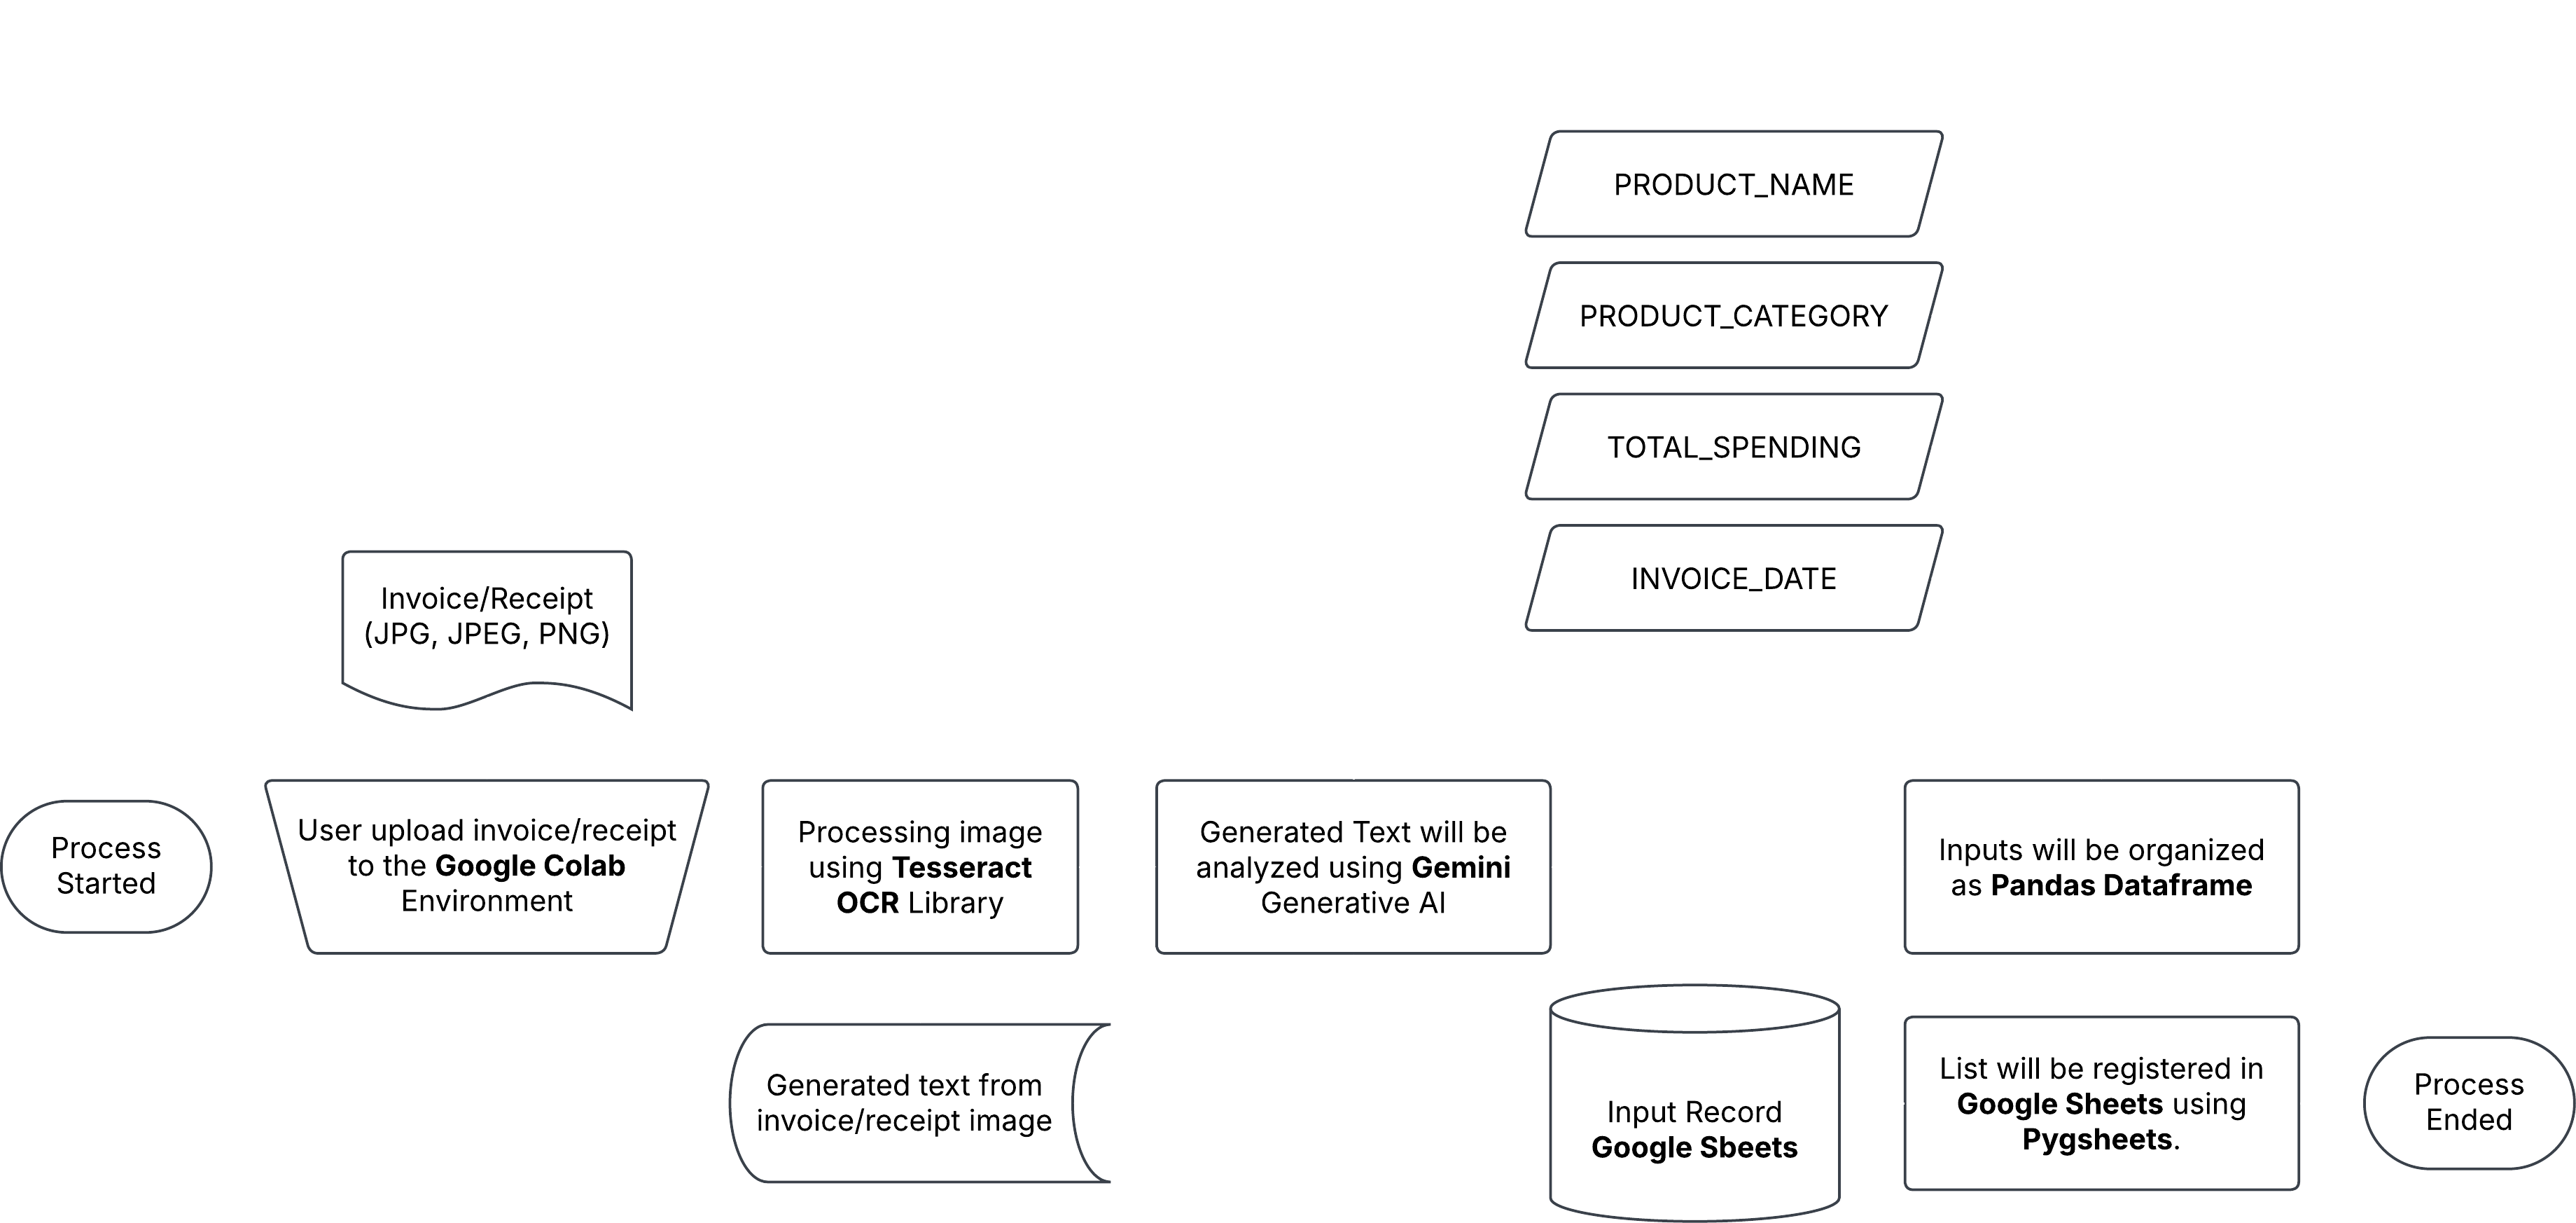







In [1]:
!pip install pytesseract
!pip install -q -U google-genai
!pip install pygsheets
!pip install pandas
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

from PIL import Image
from google.colab import files
from apiclient import discovery
from google.oauth2 import service_account
from google.cloud import storage
from google import genai
import pytesseract
import pygsheets
import numpy as np
import pandas as pd
import base64
import json
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.0/141.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 3.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,647 kB/s)
debconf: u

# **Article 2 : Setting-Up Google Workspace API to the Colab Environment**

***This code block should be only run once.***

-

Before running the code block, one should register a project on the **Google Workspace / Google Cloud Service** to be able to create a Google Service Account. The step-by-step tutorial on how to create a Google Service Account could be seen in this youtube link given below.

> [(YouTube) Foudroyer - How to create service account credentials on Google Platform ?](https://www.youtube.com/watch?v=gEzNV9sAs6g)

-

After generating the (.json) file, one should rename it to **"credentials.json"** and upload it to the **Google Colab Environment** by running:

```
files.upload()
```

Which open an upload box that demands user to choose the file from local directory. This credential will be turned into (.txt) code to be able to recognizable in the environment through **BASE64 Encoding** which will be assigned as a key to access the **Google Workspace Project Files** which contain the Spreadsheet that will be used to store the code block output. The code given below is adapted from the source given below.

> [Stack Overflow Answer by Elijas Dapšauskas](https://stackoverflow.com/a/77830696)

-

The last item in this code block is:

```
i = 2
```

Which used to determine the initial position (row in Spreadsheet) when the next code block processed output is being registered in the assigned Google Sheets.


In [7]:
# Uploading Google Service Account Credentials (.json).
credupl = files.upload()

# Converting (.json) credential details into executable (.txt) key that registered as BASE64_ENCODED_CREDENTIALS_JSON.
with open("credentials.json", "rb") as key_file:
    key_data = key_file.read()
    encoded_key = base64.b64encode(key_data)
    with open("encoded.txt", "wb") as encoded_file:
        encoded_file.write(encoded_key)

with open("credentials.json", "rb") as key_file:
    key_data = key_file.read()
    encoded_key = base64.b64encode(key_data).decode()

os.environ["BASE64_ENCODED_CREDENTIALS_JSON"] = encoded_key

# Registering Google Service Account Credentials to be able to access several APIs related to Google Workspace.
gcp_json_credentials_dict = json.loads(base64.b64decode(os.environ["BASE64_ENCODED_CREDENTIALS_JSON"]))
credentials = service_account.Credentials.from_service_account_info(gcp_json_credentials_dict)
client = storage.Client(project=gcp_json_credentials_dict['project_id'], credentials=credentials)

# Declare initial value (row_number) when updating Google Sheet.
i = 2

# **Article 3 : Generating Output Variables from Uploaded Invoice/Receipt**
***1st Repeatable Step***

-

This code block contain the system main process, such as uploading receipt/invoice into the **Google Colab Environment**, convert receipt/invoice images into string/text using **Pytesseract**, and forwarded its result to be processed using **Gemini** Generative AI. The prompt used is describes as follows:


```
(TASK) From the invoice given above please highlight the
(IN A TEXT, LOOK FOR:)
(1ST ITEM - Given) product or service name,
(2ND ITEM - Given) total amount of money spent,
(3RD ITEM - Given) transaction date,
(4TH ITEM - Processed) and from several these several categories:
    (HOBBIES, FOOD, PARKING, AMMENITIES, ELECTRONICS, MEDICINE), -> Listed Categories
    which one of them is closely related to the invoice? -> Make Decision = Output

(CONSTRAINT) Please write the answer using this format
(1ST ITEM - NO CONSTRAINT) Product Name,
(4TH ITEM - NO CONSTRAINT) Category,
(2ND ITEM - CLEAR FORMATTING) Total Amount of Money Spent (Numbers only, without full stop or comma),
(3RD ITEM - REFORMATTING) Transaction Date (in MM/DD/YYY Format).
(IN OUTPUT, REORDER LIST INTO 1=1, 4=2, 2=3, 3=4)

(FINAL OUTPUT LIMITER) DO NOT RETURN ANYTHING ELSE
(AVOID USAGE OF NARATIVE WORDS, RETURN ONLY ASKED INFORMATION IN SPECIFIC FORMAT)
```

-

The output of this code block should be displayed in this format:

> **(1) Product Name, (2) Category, (3) Price, (4) Transaction Date**

User may check the accuracy of information given in the output, the prompt itself is already backtested using several invoice/receipt sample with different formats. Missing information may occur from the OCR process which quality could be compromised based on image quality. If there are missing information or typos, user may retake the receipt/invoice photos to be able to provide higher quality images that could be accurately processed.

-

If this code block have already have the desirable output, one may proceed to the next code block which function to store the processed data into the Google Sheet. This code block requires **Gemini API Key** to be activated, step-by-step tutorial on how to acquire API Key can be seen in the link given below:


> [How to Generate a Google Gemini API Key by Rohane Hamilton](https://www.youtube.com/watch?v=o8iyrtQyrZM)



In [8]:
# Uploading receipt/invoice image in (.jpg/.jpeg/.png) format.
uploaded = files.upload()

# "uploaded" variable returns a dict, which key (without its values) will be returned using this following lines of code.
for key in uploaded:
  print(key)

# "filename" variable used to define "key" given before which is exactly the name of uploaded image file.
# "img" variable is used to convert image into numerical matrix which will be processed into string text using pytesseract in "invtext" variable.
filename = key
img = np.array(Image.open(filename))
invtext = pytesseract.image_to_string(img)

# Text generated by pytesseract will be used as a data source that will be processed according to the prompt given below.
# Prompt will return list in this format:
# ['ITEM_NAME', 'CATEGORY', 'PRICE', 'DATE']
# To achieve consistent result DO NOT CHANGE THE PROMPT, except for the list of categories which could be changed if necessary.
client = genai.Client(api_key="GOOGLE_GEMINI_API_KEY")
response = client.models.generate_content(
    model="gemini-2.0-flash", contents=invtext+"From the invoice given above please highlight the product or service name, total amount of money spent, transaction date, and from several these several categories (HOBBIES, FOOD, PARKING, AMMENITIES, ELECTRONICS, MEDICINE), which one of them is closely related to the invoice? Please write the answer using this format Product Name, Category, Total Amount of Money Spent (Numbers only, without full stop or comma), Transaction Date (in MM/DD/YYY Format). DO NOT RETURN ANYTHING ELSE"
)

# These lines of code is used for array format conditioning.
invarray = response.text.split(",")
invarray[3] = invarray[3].replace("\n","")
invarray = np.transpose(invarray)

# Print output list to check and confirm the accuracy of processing method.
print(response.text)

Saving topedlrp.jpg to topedlrp (1).jpg
topedlrp (1).jpg
La Roche Posay Effaclar Foaming Gel +M Cleanser, MEDICINE, 360370, 03/03/2025



# **Article 4 : Accessing and Editing Google Sheets**

***2nd Repeatable Step***

-

This last step of the process is used to authenticate account and grant access to the **Google Workspace API**. Once granted, one could edit the document (in this case Google Sheets) by defining its document ID which could be copied from the document link and the page/sheet name.

> https://docs.google.com/spreadsheets/d/"DOCUMENT_ID"/edit?gid=0#gid=0

Edited result could be seen directly in the given sheet and will be updated real-time for each input.

**DO NOT FORGET TO ENABLE GOOGLE SHEET API ON THE GOOGLE CLOUD PROJECT**.

In [9]:
# Converting output list into a Pandas Dataframe.
df_data = pd.DataFrame(invarray)

# Proceed authentication process to be able to access the Google Workspace API (Sheets).
SCOPES = ('https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive')
google_credentials = gcp_json_credentials_dict
my_credentials = service_account.Credentials.from_service_account_info(google_credentials, scopes=SCOPES)
gc = pygsheets.authorize(custom_credentials=my_credentials)

# Defining Google Sheet ID (key), and its sheet name to give edit access to the defined sheet.
spreadsheet_key= 'GOOGLE_SHEETS_FILE_ID'
sh = gc.open_by_key(spreadsheet_key)
wks_name = 'GOOGLE_SHEETS_PAGE_NAME'

# Accessing worksheet, and edit according to the output list given in the last code block.
wks = sh.worksheet_by_title(wks_name)
wks.set_dataframe(df_data.T, (i,1), overwrite=False,fit=False,copy_head=False)

# Redefining edit point (row) so the next output will be written in the row below and not overwrite the existing output.
i = i + 1